In [5]:
# Run from colab only
from google.colab import drive
drive.mount('/content/gdrive')
!unzip "/content/gdrive/My Drive/Colab Notebooks/small.zip"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Archive:  /content/gdrive/My Drive/Colab Notebooks/small.zip
   creating: small/
  inflating: small/.DS_Store         
   creating: __MACOSX/
   creating: __MACOSX/small/
  inflating: __MACOSX/small/._.DS_Store  
   creating: small/test/
   creating: small/test/dogs/
  inflating: small/test/dogs/dog.2058.jpg  
  inflating: small/test/dogs/dog.2064.jpg  
  inflating: small/test/dogs/dog.2070.jpg  
  inflating: small/test/dogs/dog.2110.jpg  
  inflating: small/

In [1]:
train_dir='small/train/'
validation_dir='small/validation/'
test_dir='small/test/'

In [2]:
import sys, os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

1.4.0


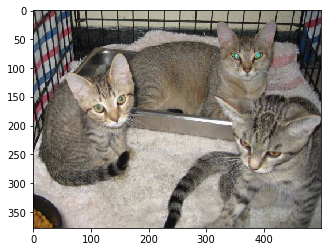

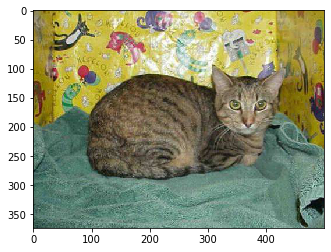

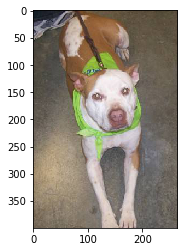

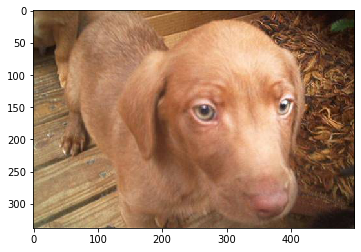

In [3]:
cats_dir=os.path.join(test_dir, 'cats')
fnames = [os.path.join(cats_dir, fname) for fname in os.listdir(cats_dir)][:2]
dogs_dir=os.path.join(test_dir, 'dogs')
fnames.extend([os.path.join(dogs_dir, fname) for fname in os.listdir(dogs_dir)][:2])

import matplotlib.image as mpimg
# Read the image and resize it
i=0
for img_path in fnames:
  img=mpimg.imread(img_path)
  plt.figure(i)
  plt.grid(False)
  imgplot = plt.imshow(img)
  i+=1

plt.show()

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    train_loss = 0.0
    total_train = 0
    correct_train = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            display('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), display_id=str(epoch), update=True)

        # accuracy
        _, predicted = torch.max(output.data, 1)
        train_loss += loss.item()
        total_train += target.nelement()  # number of pixel in the batch
        correct_train += predicted.eq(target.data).sum().item() # sum all precited pixel values

    epoch_loss = train_loss / len(train_loader.dataset)
    epoch_acc = 100.*(correct_train / total_train)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} {:.0f}%\n'.format(
      epoch_loss,correct_train, total_train, epoch_acc))
    return epoch_loss,epoch_acc

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy=100. * correct / len(test_loader.dataset)

    print('Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      accuracy))
    return test_loss,accuracy

# **Pre-trained models**

In [5]:
batch_size = 32
INPUT_SIZE=256
use_cuda = torch.cuda.is_available()
print(use_cuda)

torch.manual_seed(1)

preprocess=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=preprocess)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
val_dataset = torchvision.datasets.ImageFolder(root=validation_dir, transform=preprocess)
val_loader  = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, **kwargs) 
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=preprocess)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs) 

print(len(train_dataset), len(val_dataset), len(test_dataset))

False
512 256 256


In [6]:
our_labels=train_dataset.classes
print(our_labels)

['cats', 'dogs']


# Fine-tuning

In [7]:
#adapted from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def set_parameter_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [8]:
from torchvision import models
cnn_model = models.mobilenet_v2(pretrained=True)
print(cnn_model)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/ruaihm4/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth



MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=T

In [9]:
device = torch.device("cuda" if use_cuda else "cpu")
num_classes=len(train_dataset.classes)
print(num_classes)
#cnn_model.classifier[-1]=nn.Linear(in_features=1280, out_features=num_classes)
cnn_model.classifier=nn.Sequential(nn.Linear(in_features=1280, out_features=num_classes))

2


In [10]:
#head only
set_parameter_requires_grad(cnn_model.features, requires_grad=False)
epochs = 3
cnn_model=cnn_model.to(device)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, cnn_model.parameters()), lr=0.1)
#scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(cnn_model, device, train_loader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(cnn_model, device, val_loader)
    val_accuracies.append(val_accuracy)
    #scheduler.step()

Train set: Average loss: -4.0467, Accuracy: 430/512 84%

Val set: Average loss: -267.4875, Accuracy: 247/256 (96%)

Train set: Average loss: -12.6693, Accuracy: 470/512 92%

Val set: Average loss: -551.1209, Accuracy: 247/256 (96%)

Train set: Average loss: -21.3299, Accuracy: 485/512 95%

Val set: Average loss: -829.9893, Accuracy: 247/256 (96%)



In [11]:
score = test(cnn_model, device, test_loader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: -837.5912, Accuracy: 244/256 (95%)

Test loss: -837.5912475585938
Test accuracy: 95.3125


# Save for mobile

In [12]:
saved_model=cnn_model.to('cpu')

In [13]:
from PIL import Image
saved_model.eval()
for img_path in fnames:
    img = Image.open(img_path)
    img_tensor = preprocess(img)
    img_tensor.unsqueeze_(0)
    preds = saved_model(img_tensor)
    preds=preds[0].data.numpy()
    top_index = preds.argmax()
    print(preds,top_index,our_labels[top_index])

[935.4083 825.6714] 0 cats
[821.3692  742.93616] 0 cats
[818.0804 956.3217] 1 dogs
[805.2005 912.521 ] 1 dogs


In [14]:
example = torch.rand(1, 3, INPUT_SIZE, INPUT_SIZE)
traced_script_module = torch.jit.trace(saved_model, example)
traced_script_module.save("../mobile_app/app/src/main/assets/catdog_model.pt")

In [15]:
saved_model = torch.jit.load("../mobile_app/app/src/main/assets/catdog_model.pt")
saved_model.eval()
print(saved_model)

RecursiveScriptModule(
  original_name=Module
  (features): RecursiveScriptModule(
    original_name=Module
    (0): RecursiveScriptModule(
      original_name=Module
      (0): RecursiveScriptModule(original_name=Module)
      (1): RecursiveScriptModule(original_name=Module)
      (2): RecursiveScriptModule(original_name=Module)
    )
    (1): RecursiveScriptModule(
      original_name=Module
      (conv): RecursiveScriptModule(
        original_name=Module
        (0): RecursiveScriptModule(
          original_name=Module
          (0): RecursiveScriptModule(original_name=Module)
          (1): RecursiveScriptModule(original_name=Module)
          (2): RecursiveScriptModule(original_name=Module)
        )
        (1): RecursiveScriptModule(original_name=Module)
        (2): RecursiveScriptModule(original_name=Module)
      )
    )
    (2): RecursiveScriptModule(
      original_name=Module
      (conv): RecursiveScriptModule(
        original_name=Module
        (0): RecursiveScriptMo